# Energy Consumption Forecasting with LSTMs using TensorFlow 2 and Keras  

## Data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [46]:
df = pd.read_csv('energy_data.csv')

In [47]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [48]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [49]:
# checking for null values 
df.isnull()

,Datetime,AEP_MW
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
121268,False,False
121269,False,False
121270,False,False
121271,False,False


In [50]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

## Feature Extraction: Reformatting the Date Time columns

 The date is in the YYYY-MM-DD HH:MM:SS format. We will extract the year, month, date, day, week and time seperately from the 'Datetime' column. 

In [51]:
dataset = df 
dataset['Month']= pd.to_datetime(df['Datetime']).dt.month
dataset['Year']= pd.to_datetime(df['Datetime']).dt.year
dataset['Date']= pd.to_datetime(df['Datetime']).dt.date
dataset['Day']= pd.to_datetime(df['Datetime']).dt.day_name()
dataset['Week']= pd.to_datetime(df['Datetime']).dt.week
dataset['Time']= pd.to_datetime(df['Datetime']).dt.time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [52]:
df.head()

,Datetime,AEP_MW,Month,Year,Date,Day,Week,Time
0,2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,Friday,53,01:00:00
1,2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,Friday,53,02:00:00
2,2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,Friday,53,03:00:00
3,2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,Friday,53,04:00:00
4,2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,Friday,53,05:00:00


In [53]:
df['Year'].unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [54]:
df['Year'].nunique()

15

### Yearly energy consumption 

Text(0.5, 1.0, 'Yearly Energy Consumption')

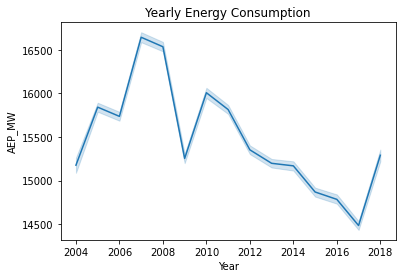

In [55]:
fig= plt.figure()
ax1= plt.subplot2grid((1,1),(0,0))

sns.lineplot(x='Year', y='AEP_MW', data=df)

plt.title('Yearly Energy Consumption')

Looks like the energy consumption peaked in 2006-2007. Understanding on what days and at what times of the day energy peaks will help us create an accurate ML- model. 

In [56]:
df_2005= df[df['Year']== 2005]
df_2006= df[df['Year']== 2006]
df_2007= df[df['Year']== 2007]


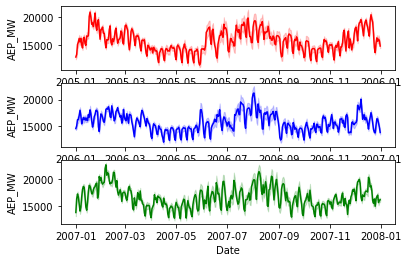

In [57]:
f, axes = plt.subplots(3, 1)

sns.lineplot(x= 'Date', y='AEP_MW', data= df_2005, ax=axes[0], color='red') 
sns.lineplot(x= 'Date', y='AEP_MW', data= df_2006, ax=axes[1], color='blue')
sns.lineplot(x= 'Date', y='AEP_MW', data= df_2007, ax=axes[2], color='green') 



In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
 2   Month     121273 non-null  int64  
 3   Year      121273 non-null  int64  
 4   Date      121273 non-null  object 
 5   Day       121273 non-null  object 
 6   Week      121273 non-null  int64  
 7   Time      121273 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 7.4+ MB


### Resampling 

We need to resample because we have over 120,000 data points. So instead of having hourly values, we rasample such that we have only one value per day. We will only consider the average value per day.  

In [59]:
df_1 = pd.read_csv("energy_data.csv", parse_dates =["Datetime"], index_col ="Datetime")


In [60]:
df_1

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


In [61]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
 2   Month     121273 non-null  int64  
 3   Year      121273 non-null  int64  
 4   Date      121273 non-null  object 
 5   Day       121273 non-null  object 
 6   Week      121273 non-null  int64  
 7   Time      121273 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 7.4+ MB


In [65]:
df['Datetime']= pd.to_datetime(df['Datetime'])

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
 2   Month     121273 non-null  int64         
 3   Year      121273 non-null  int64         
 4   Date      121273 non-null  datetime64[ns]
 5   Day       121273 non-null  object        
 6   Week      121273 non-null  int64         
 7   Time      121273 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 7.4+ MB


In [67]:
df= df.set_index('Datetime')

In [68]:
df

,AEP_MW,Month,Year,Date,Day,Week,Time
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,Friday,53,01:00:00
2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,Friday,53,02:00:00
2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,Friday,53,03:00:00
2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,Friday,53,04:00:00
2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,Friday,53,05:00:00
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,1,2018,2018-01-01,Monday,1,20:00:00
2018-01-01 21:00:00,20999.0,1,2018,2018-01-01,Monday,1,21:00:00
2018-01-01 22:00:00,20820.0,1,2018,2018-01-01,Monday,1,22:00:00


In [69]:
New_df= df.resample('D').mean()

In [71]:
New_df.shape

(5055, 4)

In [72]:
df.shape

(121273, 7)

In [73]:
test_data= New_df.tail(100)

In [74]:
training_data= New_df.iloc[:,0:1]

In [75]:
training_data= training_data[:-60]

In [76]:
training_data.shape

(4995, 1)

In [77]:
test_data.shape

(100, 4)

In [86]:
sc= MinMaxScaler(feature_range=(0,1))
train= sc.fit_transform(training_data)
train.shape[0]

4995

In [87]:
X_train= []
y_train= []

for i in range(60, train.shape[0]):
  X_train.append(train[i-60:i])
  y_train.append(train[i])


#converting to numpy array
X_train= np.array(X_train)
y_train= np.array(y_train)



In [88]:
X_train.shape #(datapoints, steps, 1)

(4935, 60, 1)

In [89]:
y_train.shape

(4935, 1)

In [91]:
X_train= np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4935, 60, 1)

## Model

In [92]:
from keras.models import Sequential


In [93]:
from keras.layers import Dense,LSTM
from tensorflow.keras.layers import Dense, Dropout

In [95]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [96]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)


Epoch 1/50
155/155 [==============================] - 29s 128ms/step - loss: 0.0238
Epoch 2/50
155/155 [==============================] - 20s 127ms/step - loss: 0.0187
Epoch 3/50
155/155 [==============================] - 19s 126ms/step - loss: 0.0178
Epoch 4/50
155/155 [==============================] - 20s 128ms/step - loss: 0.0167
Epoch 5/50
155/155 [==============================] - 21s 133ms/step - loss: 0.0159
Epoch 6/50
155/155 [==============================] - 20s 128ms/step - loss: 0.0158
Epoch 7/50
155/155 [==============================] - 19s 125ms/step - loss: 0.0151
Epoch 8/50
155/155 [==============================] - 20s 131ms/step - loss: 0.0149
Epoch 9/50
155/155 [==============================] - 20s 128ms/step - loss: 0.0137
Epoch 10/50
155/155 [==============================] - 21s 136ms/step - loss: 0.0120
Epoch 11/50
155/155 [==============================] - 20s 126ms/step - loss: 0.0101
Epoch 12/50
155/155 [==============================] - 19s 122ms/step - lo

## Test Data

In [98]:
test_data.shape

(100, 4)

In [99]:
df_fin= pd.concat((New_df[['AEP_MW']], test_data[['AEP_MW']]), axis=0)

In [100]:
df_fin.shape

(5155, 1)

In [101]:
inputs= df_fin[len(df_fin)- len(test_data)- 60:].values
inputs.shape

(160, 1)

In [102]:
#reshaping 
inputs= inputs.reshape(-1,1)

#normalization 
inputs= sc.transform(inputs)

X_test= []
for i in range(60,160):
  X_test.append(inputs[i-60: i])

#convert to numpy array
X_test= np.array(X_test)

#reshaping 
X_test= np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#pass to model 
predicted_price= regressor.predict(X_test)

#inverse transforming to get the actual values
predicted_price= sc.inverse_transform(predicted_price)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [103]:
real_MW= test_data['AEP_MW'].to_list()
predicted_MW = predicted_price
dates= test_data.index.to_list()

In [104]:
ml_df= pd.DataFrame(data={
    'Date': dates,
    'Actual_MW': real_MW,
    'Predicted_MW': [x[0] for x in predicted_MW]})

In [105]:
ml_df

,Date,Actual_MW,Predicted_MW
0,2018-04-26,13157.791667,13501.047852
1,2018-04-27,12964.000000,13124.725586
2,2018-04-28,12237.583333,14863.189453
3,2018-04-29,12156.791667,13399.761719
4,2018-04-30,13443.500000,12890.605469
...,...,...,...
95,2018-07-30,15368.083333,15562.440430
96,2018-07-31,15180.291667,15508.462891
97,2018-08-01,15151.166667,15085.283203
98,2018-08-02,15687.666667,15031.160156


In [106]:
real_MW= test_data['AEP_MW'].to_list()
predicted_MW= [x[0] for x in predicted_MW]
dates= test_data.index.to_list()

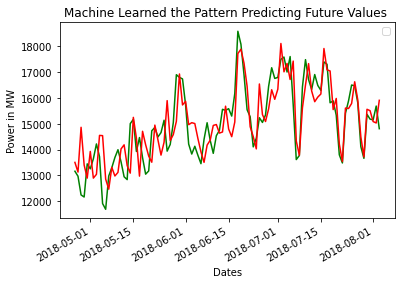

In [107]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = real_MW

y1 = predicted_MW

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()